# Generating Layers from Renal MRI Data
In this tutorial we'll use the 3D Quantitative Layers (`qlayers`) package to analyse renal MRI data. The premise behind `qlayers` was first proposed by [Pruijm et al](https://doi.org/10.1007/s10334-019-00808-5) and is based on the idea to segment the kidney into layers based on each voxels distance from the surface of the kidney. The average of a quantitative parameter can be calculated for each layer producing profiles of, for example, $T_2^*$ with depth. The outer and inner layers are analogous to the cortex and medulla respectively while the gradient of the profile is representative of the cortico-medullary difference. `qlayers` extends this idea by allowing the user to define layers based on a 3D mask and apply the layer to any quantitative parameter.

The data used in this tutorial can be downloaded from Zenodo. In addition to the dependencies in `requirements.txt` this 
notebook also needs you to add `jupyter`, `matplotlib` and `seaborn` to your Python environment.

In [1]:
# Import the dependencies we're going to need
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import seaborn as sns

from qlayers import QLayers, cortical_thickness, slope

sns.set()


def show_slice(img, slice, ax, cmap='gray', clim=None):
    if type(img) is str:
        img = nib.load(img)
    data = img.get_fdata()
    sl = data[:, :, slice]
    if clim is None:
        clim = (sl.min(), sl.max())
    ax.imshow(sl.T, origin='lower', cmap=cmap, clim=clim)
    ax.axis(False)

## Generating Layers
QLayers analysis is based around the `QLayers` object. This class takes a binary kidney mask and calculates the distance from every voxel in the kidneys to the surface of each kidney. We can the apply this information to interrogate quantitative maps of the kidneys acquired in the same session. The work by Pruijm et al uses layer analysis with $R_2^*$ maps so we'll do that here. The QLayers class does quite a lot of things automatically so we're going to run it, save lots of its outputs as niftis, then explore them.

In [2]:
# Load a 3D binary mask of the kidneys, this mask was made automatically from the T2-weighted anatomical scan, we're also going to load the anatomical so we can give the results some context in the body.
mask_img = nib.load('data/kidney_mask.nii.gz')
t2w_img = nib.load('data/t2w.nii.gz')
qlayers = QLayers(mask_img, thickness=5, pelvis_dist=10, space='layers')
qlayers.save_depth('data/depth.nii.gz')
qlayers.save_layers('data/layers.nii.gz')
qlayers.save_pelvis('data/pelvis.nii.gz')

Making Mesh
Smoothing Mesh


Pelvis Distance Calculation: 100%|██████████| 3/3 [00:10<00:00,  3.36s/it]


In the above cell we've taken our binary mask, filled any holes in the mask (usually caused by cysts) and segmented the renal pelvis (saved out as `pelvis.nii.gz`). The distance from the surface of the kidney to each voxel is then calculated (saved as `depth.nii.gz`), using the depth maps regions of interest labels are defined based on the `thickness` parameter (saved as `layers.nii.gz`). Here we've set the `thickness` to be 5 mm which is much more than usual, but means you can see the different layers in the figure below. Any tissue within 10 mm of the pelvis is excluded from the depth/layer maps as it is not representative of the rest of the kidney.

Text(0.5, 1.0, 'Layers')

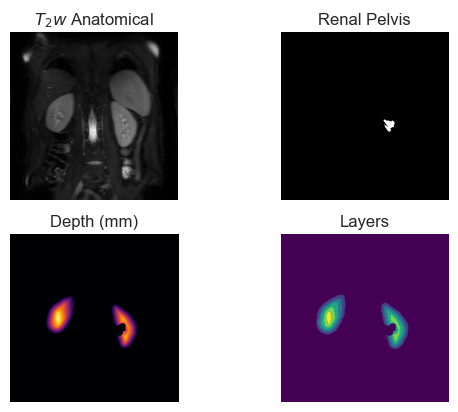

In [3]:
fig, ax = plt.subplots(2, 2)
sl = 8
show_slice(t2w_img, sl, ax[0, 0])
ax[0, 0].set_title('$T_2w$ Anatomical')
show_slice('data/pelvis.nii.gz', 4, ax[0, 1])
ax[0, 1].set_title('Renal Pelvis')
show_slice('data/depth.nii.gz', sl, ax[1, 0], cmap='inferno')
ax[1, 0].set_title('Depth (mm)')
show_slice('data/layers.nii.gz', sl, ax[1, 1], cmap='viridis')
ax[1, 1].set_title('Layers')

## Applying Layers to Quantitative Maps
Now we've seen the layers, re-initalise the object with a thickness of 1 mm and our $R_2^*$ map to the layers and explore it a bit. The primary way of getting data from a layers object is as a Pandas DataFrame. Your quantitative map and mask/anatomical image don't need to have the same field of view and voxel size, they are resampled to a common space as part of the `add_map` method. The `space` parameter of the QLayers class dictates whether any maps added to the object are resampled of the same space as the layers (`space=layers`) or if the layers are resampled to the native space of the map (`space=map`). The advantage of working in layer space is that you can produce a wide DataFrame where each row represents a region of tissue in the image and allows you to directly compare the depth and multiple quantitative parameters however it does involve a resampling operation to the quantitative parameter which may not be desirable (especially for noisy data). Working with `space=map` only allows you to produce a long DataFrame where each row is a single voxel of each quantitative map. Here we're going to work with `space=layers` and return both formats of DataFrame so you can see the differetnce. Most analysis is easier with a wide DataFrame so we'll save that variable for use in subsequent steps.

In [4]:
qlayers = QLayers(mask_img, thickness=1, pelvis_dist=10, space='layers')
r2star_map = nib.load('data/r2star.nii.gz')
t1_map = nib.load('data/t1_registered.nii.gz')
qlayers.add_map(r2star_map, 'r2star')
qlayers.add_map(t1_map, 't1')

Making Mesh
Smoothing Mesh


Pelvis Distance Calculation: 100%|██████████| 3/3 [00:10<00:00,  3.49s/it]
D:\ppzajd\NextCloud\University\Renal Imaging\Layers\qlayers\qlayers\quant_layers.py:127: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.df_long = pd.concat([self.df_long, sub_df])


In [5]:
print('An example of a long DataFrame')
qlayers.get_df('long').sample(n=100)

An example of a long DataFrame


,depth,layer,measurement,value
14871,0.135132,1.0,t1,5.796324e+02
12976,8.921336,9.0,r2star,1.152017e-06
22323,9.009458,10.0,t1,1.585159e+03
2140,0.172214,1.0,r2star,3.344193e+01
22105,16.332839,17.0,t1,2.053183e+03
...,...,...,...,...
9960,1.682465,2.0,r2star,1.626839e+01
11617,1.876681,2.0,r2star,-3.239040e-07
16429,12.079811,13.0,r2star,-6.251760e-06
5723,4.351147,5.0,t1,1.673765e+03


In [6]:
df = qlayers.get_df('wide')
# A little bit of data cleaning
df = df.loc[df['r2star'] > 0.1]
df = df.loc[df['t1'] > 0.1]
df = df.loc[df['layer'] > 0]
df = df.dropna()
print('An example of a wide DataFrame')
df.sample(n=100)

An example of a wide DataFrame


,depth,layer,r2star,t1
3018,15.063256,16.0,21.360178,1604.783691
9633,4.547732,5.0,17.030762,1490.808350
787,5.234842,6.0,17.800167,1482.557739
9332,3.725557,4.0,30.825502,2080.433594
24907,9.180894,10.0,18.437084,1701.755249
...,...,...,...,...
9084,8.471676,9.0,16.023804,1633.775513
11685,8.877754,9.0,17.867966,1781.867065
5407,8.993038,9.0,42.974960,1666.143066
16966,3.280084,4.0,14.413002,1511.425781


The good thing about Pandas DataFrames is they make lots of operations relatively simple. Here we're going to calculate the average and standard deviation $R_2^*$ in each layer, this could be saved out as an image derived parameter for larger cohort analysis. We'll then plot this profile using `seaborn`.

In [7]:
df[['layer', 'r2star', 't1']].groupby('layer').agg((np.mean, np.median, np.mode, np.std, np.count_nonzero))

AttributeError: module 'numpy' has no attribute 'mode'

In [ ]:
fig, ax = plt.subplots()
sns.lineplot(df, x='layer', y='r2star', ax=ax, estimator='median')
ax.set_xlabel('Depth (mm)')
ax.set_ylabel('$R_2^*$ (Hz)')
ax.set_ylim((15, 35))
ax.axvspan(0, 5, alpha=0.2, label='Outer Layers', color='C2')
ax.axvspan(15, 23, alpha=0.2, label='Inner Layers', color='C5')
ax.legend()

From these profiles we calculate more image derived parameters. Taking the average of the outer layers is analogous to taking the average of the cortex, similarly taking the average of the inner layer is analogous to taking the average of the medulla. Finally we can calculate the gradient of the central profile which gives information about the cortico-medullary difference. To make things easier, the `qlayers` package has a helper function to do all this in one go. We're going to use the outer 5 mm of tissue as the outer region and tissue deeper than 15 mm as the inner region. You can set the `unit` argument to percent to use, for example, the outer 10 %  and inner 10 % to define the regions and thus control for kidney size.

In [ ]:
grads = slope(qlayers, outer=5, inner=15, unit='mm')
print(f"Average Outer R2* = {grads.loc['r2star', 'outer']:.2f} +/- {grads.loc['r2star', 'outer_std']:.2f} Hz")
print(f"Average Inner R2* = {grads.loc['r2star', 'inner']:.2f} +/- {grads.loc['r2star', 'inner_std']:.2f} Hz")
print(f"Average R2* Grad  = {grads.loc['r2star', 'grad']:.2f} +/- {grads.loc['r2star', 'grad_se']:.2f} Hz/mm")
grads_percent = slope(qlayers, outer=10, inner=90, unit='percent')
grads

## Working with Tissues and Layers
We can

In [ ]:
tissue_img = nib.load('data/tissue.nii.gz')
qlayers = QLayers(mask_img, thickness=1, pelvis_dist=10, space='layers')
qlayers.add_tissue(tissue_img, ['Cortex', 'Medulla'])
# qlayers.add_map(r2star_map, 'r2star')
# qlayers.add_map(t1_map, 't1_registered')

In [ ]:
fig, ax = plt.subplots(1, 2)
sl = 7
show_slice(t2w_img, sl, ax[0])
ax[0].set_title('$T_2w$ Anatomical')
show_slice(tissue_img, sl, ax[1])
ax[1].set_title('Tissues')
tissue = tissue_img.get_fdata()
np.unique(tissue)

In [ ]:
thickness = cortical_thickness(qlayers)
fig, ax = plt.subplots()
sns.histplot(qlayers.get_df('wide'), x='depth', hue='tissue', ax=ax)
ax.set_xlabel('Depth (mm)')
ax.set_ylabel('Voxel Count')

In [ ]:
df = qlayers.get_df('wide')
df.loc[df['tissue'] == 'Medulla'].sort_values('depth').head(100)